In [11]:
import numpy as np
from matplotlib import pyplot as plt
import DataUtils as data

plt.style.use("dark_background")

In [ ]:
# TODO: Use EM to re-estimate the A matrix

In [119]:
class KalmanFilter():
    """
    Initialization:
    1. Initialize state of the filter
    2. Initialize belief of the state

    Predict:
    1. Use process model to predict state at the next time step
    2. Adjust belief to account for hte uncertainty in prediction

    Update:
    1. Get a measurement & associated belief about its accuracy
    2. Compute residual between estimated state & measurement
    3. Compute scaling factor absed on whether the measurement or prediction
    is more accurate
    4. Set state between prediction & measurement based on scaling factor
    5. Update belief in the state based on how certain we are in the measurement
    """
    def __init__(self, prior, A, C, Q):
        '''

        '''


        self.prior = prior

        self.A = A
        self.C = C
        self.previous_mean = None
        self.previous_time = 0

        self.Q = Q # system cov

        self.mean = prior
        self.cov = np.eye(6)

        self.Kalman_gain = None
        self.mean_predict = None
        self.cov_predict = None

    def predict(self, R):
        self.mean_predict = self.A @ self.mean
        self.cov_predict = self.A @ self.cov @ self.A.T + R

        self.Kalman_gain = self.cov_predict @ self.C.T @ np.linalg.inv( self.C @ self.cov_predict @ self.C.T + self.Q )

    def update(self, measurement):
        shape = self.Kalman_gain.shape[0]
        # self.mean_predict = self.C @ measurement
        self.cov = (np.eye(shape,dtype=float) - self.Kalman_gain @ self.C) @ self.cov_predict
        temp_change = self.Kalman_gain @ (measurement.reshape(shape,1) - (self.C @ self.mean_predict))
        temp_change[3:] = np.zeros((3, 1))

        print(temp_change)

        self.mean = self.mean_predict + temp_change

        print(self.mean,  "\n-----------------------")

    def curr_state(self):
        return self.mean, self.cov

    def get_predictions(self, measurements):
        shape = self.cov.shape[0]

        states = np.zeros(shape=(shape, measurements.shape[1]),dtype=float)
        states[:,0] = self.prior.reshape(-1)
        for i in range(1,measurements.shape[1]):
            self.predict()
            self.update( measurements[:,i] )
            states[:,i] = self.currState()[0].reshape(-1)

        return states

In [25]:
# Load Data
data_interface = data.DataInterface(
    "/home/jay/Documents/urban16/sensor_data/gps.csv",
    "/home/jay/Documents/urban16/sensor_data/xsens_imu.csv",
    "/home/jay/Documents/urban16/sensor_data/encoder.csv"
)

In [120]:
data_interface.reset()

In [121]:
radius = 6371
A = np.zeros((6,6))
A[0:3, 0:3] = np.eye(3) * 2
A[0:3, 3:6] = np.eye(3) * -1
A[3:6, 0:3] = np.eye(3)

# prior = np.array([[lon, lat, alt]]).T
# zero = np.array([[0, 0, 0]]).T
# prior= np.concatenate((prior, zero), axis = 0 )
prior = np.array([[0, 0, 0, 0, 0, 0]])

C = np.eye(6)

gps_snapshot = data_interface.read()["gps_data"]
Q = np.zeros((6,6))
temp = gps_snapshot[4:].reshape((3,3))
Q[0:3, 0:3] = temp * 2
Q[3:6, 3: 6] = temp
prior[0, 0:3] = gps_snapshot[1:4]

gps_snapshot = data_interface.read()["gps_data"]
prior[0, 3:] = gps_snapshot[1:4]

kf = KalmanFilter(prior.T, A, C, Q)

In [122]:
timestamp = 0
mean_arr = []
cov_arr = []
pre_measure = np.zeros((3,1))

for t in range(1000):
    gps_snapshot = data_interface.read()["gps_data"]

    R = np.zeros((6,6))
    temp = gps_snapshot[4:].reshape((3,3))
    R[0:3, 0:3] = temp
    R[3:6, 3:6] = temp

    kf.predict(R)
    kf.update( np.concatenate((gps_snapshot[1:4].reshape((3,1)), pre_measure), axis = 0))
    pre_measure = gps_snapshot[1:4].reshape((3,1))
    m, c = kf.curr_state()
    mean_arr.append(m)
    cov_arr.append(c)
mean_arr = np.array(mean_arr)
cov_arr = np.array(cov_arr)

[[0.17512898]
 [0.30650389]
 [0.32546018]
 [0.        ]
 [0.        ]
 [0.        ]]
[[ 37.17512898]
 [126.30650389]
 [ 36.32546018]
 [ 37.        ]
 [126.        ]
 [ 36.        ]] 
-----------------------
[[0.174856  ]
 [0.30602706]
 [0.36129107]
 [0.        ]
 [0.        ]
 [0.        ]]
[[ 37.52511396]
 [126.91903483]
 [ 37.01221142]
 [ 37.17512898]
 [126.30650389]
 [ 36.32546018]] 
-----------------------
[[-0.23784737]
 [-0.41627064]
 [-0.43013387]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[[ 37.63725156]
 [127.11529514]
 [ 37.2688288 ]
 [ 37.52511396]
 [126.91903483]
 [ 37.01221142]] 
-----------------------
[[-0.17935208]
 [-0.31389499]
 [-0.34152288]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[[ 37.57003709]
 [126.99766046]
 [ 37.1839233 ]
 [ 37.63725156]
 [127.11529514]
 [ 37.2688288 ]] 
-----------------------
[[ 0.00454103]
 [ 0.00794696]
 [-0.00955326]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[[ 37.50736364]
 [126.88797274]
 [ 37.08946454]
 [ 37.57003709]
 [126

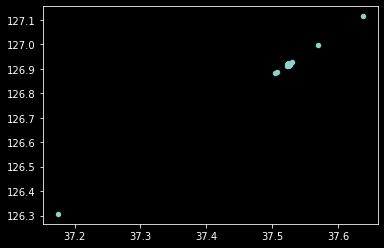

In [125]:
fig = plt.figure()
axes = fig.add_subplot()
axes.scatter(mean_arr[:, 0, :], mean_arr[:, 1, :], s=20)

In [ ]:
plotting_data = np.zeros((1000, 6))

for i in range(1000):
    plotting_data[i] = mean_arr[i].flatten()

In [ ]:
plotting_data

In [ ]:
plotting_data[:, 3].shape, plotting_data[:, 4].shape

In [ ]:
fig = plt.figure(figsize=(15, 15))
axis1 = plt.axes(projection="3d")
axis2 = plt.axes()

axis2.scatter(plotting_data[:, 0], plotting_data[:, 1])

In [ ]:
mean_arr.shape

In [ ]:
(C.T @ mean_arr).shape

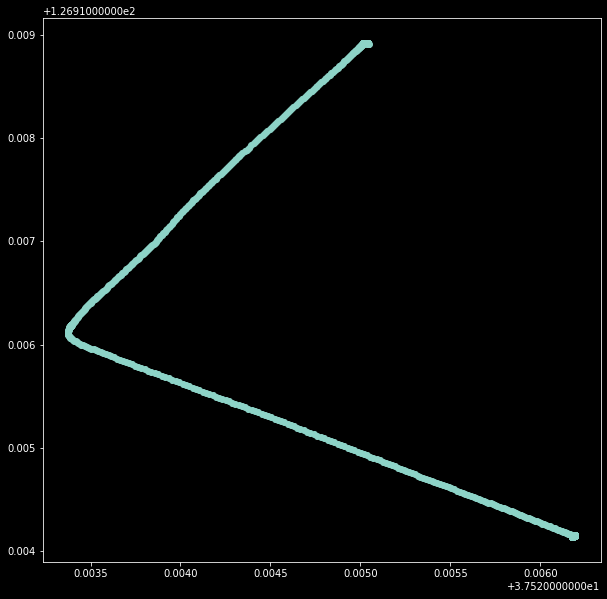

In [170]:
# plotting ground truth
gps_truth_data = np.genfromtxt("/home/jay/Documents/urban16/sensor_data/gps.csv", delimiter=",")
first_1000 = gps_truth_data[:1000, :]

fig = plt.figure(figsize=(10, 10))
axes = plt.axes()
axes.scatter(first_1000[:, 1], first_1000[:, 2])